### Preamble (required)

In [1]:
from bs4 import BeautifulSoup
import requests
from IPython.display import display, Image
import tempfile
import os
import json
from dotenv import load_dotenv
from pymongo import MongoClient
from concurrent.futures import ThreadPoolExecutor

load_dotenv("../.env")

DUMP_DIR = "./out"
OUTPUT_DIR = "./txt"

### Create scraper with sanity test (Also required)

All Servers Date
Event period: 2024-11-21 00:00:00 - 2024-12-04 00:00:00
Total item (entries) in shop: 25
Item: 'Momo Belia Deviluke'
Stock: '5'
Price: '8000'


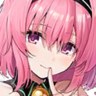

--
RES: {'dates': {'all_server': {'start': datetime.datetime(2024, 11, 21, 0, 0), 'end': datetime.datetime(2024, 12, 4, 0, 0)}}, 'shop_items': [{'name': 'Momo Belia Deviluke', 'stock': '5', 'price': '8000', 'image_url': 'https://azurlane.netojuu.com/images/thumb/f/f7/Momo_Belia_DevilukeIcon.png/96px-Momo_Belia_DevilukeIcon.png'}, {'name': 'Gear Skin Box (To LOVE-Ru)', 'stock': '10', 'price': '2000', 'image_url': 'https://azurlane.netojuu.com/images/thumb/6/69/To_LOVE-Ru_GearSkinBox.png/96px-To_LOVE-Ru_GearSkinBox.png'}, {'name': 'Cognitive Chips', 'stock': '10', 'price': '300', 'image_url': 'https://azurlane.netojuu.com/images/thumb/6/69/Cognitive_Chip.png/96px-Cognitive_Chip.png'}, {'name': 'Cognitive Array', 'stock': '5', 'price': '1000', 'image_url': 'https://azurlane.netojuu.com/images/thumb/0/0e/Cognitive_Array.png/96px-Cognitive_Array.png'}, {'name': 'Rare Cat Box', 'stock': '10', 'price': '250', 'image_url': 'https://azurlane.netojuu.com/images/thumb/8/80/Cat_Box_Rare.png/96px-C

In [12]:
### TODO: scrape every event shop.
###       only get the ones with a vaible shop (debug search for keyword item shop to check for compatability)
###       Put bad entries in a list txt file and skip in the future.
###       Serverless function? Python (reality: just rewrite in js)
# https://azurlane.koumakan.jp/wiki/Events#Limited_Event_List


import dateparser


def al_scraper(url, show=True):
    response = requests.get(url)
    if not response.ok:
        None
        print(f"Note: Failed to fetch URL: {url} (Status code: {response.status_code})")
        # raise Exception(f"Failed to fetch URL: {url} (Status code: {response.status_code})")
    soup = BeautifulSoup(response.text, "html.parser")

    en_start_date = None
    en_end_date = None
    all_start_date = None
    all_end_date = None

    # Find the EN Servers row and extract dates
    event_table = soup.find("table", class_="event-infobox")
    if event_table:
        rows = event_table.find_all("tr")
        for i, row in enumerate(rows):
            th = row.find("th")
            if th and "en server" in th.text.lower():
                if i + 2 < len(rows):
                    en_start_date = rows[i + 1].find_all("td")[1].text.strip()
                    en_end_date = rows[i + 2].find_all("td")[1].text.strip()
                    if show:
                        print("EN Servers Date")
                        print(f"Event period: {en_start_date} - {en_end_date}")
            elif th and "all server" in th.text.lower():
                if i + 2 < len(rows):
                    all_start_date = rows[i + 1].find_all("td")[1].text.strip()
                    all_end_date = rows[i + 2].find_all("td")[1].text.strip()
                    if show:
                        print(f"Event period (base): {all_start_date} - {all_end_date}")
                    all_start_date = dateparser.parse(all_start_date)
                    all_end_date = dateparser.parse(all_end_date)

                    if show:
                        print("All Servers Date")
                        print(f"Event period: {all_start_date} - {all_end_date}")

    # Find all shop items
    shop_items = soup.find_all("div", class_="item-frame")

    # Extract and print details for each item
    # Get total number of shop items
    total_items = len(shop_items)

    if not shop_items or total_items <= 0:
        return False

    if show:
        print(f"Total item (entries) in shop: {total_items}")
    for item in shop_items:
        stock = (
            item.find("div", class_="item-stock")
            .text.strip()
            .replace("Available:", "")
            .strip()
        )
        name = item.find("div", class_="item-name").text.strip()
        price = item.find("div", class_="item-price").text.strip()
        if show:
            print(f"Item: '{name}'")
            print(f"Stock: '{stock}'")
            print(f"Price: '{price}'")
        image_url = item.find("div", class_="item-image-frame").find("img")["src"]
        if not image_url.startswith("http"):
            image_url = "https://azurlane.koumakan.jp" + image_url
        # print(f"Image URL: {image_url}")

        if show:
            img = download_image(image_url, name)
            display(Image(img))
            print("--")

        # Create dictionary to store event info
        event_data = {"dates": {}, "shop_items": []}

        # Store dates
        if en_start_date:
            event_data["dates"]["en_server"] = {
                "start": en_start_date,
                "end": en_end_date,
            }
        if all_start_date:
            event_data["dates"]["all_server"] = {
                "start": all_start_date,
                "end": all_end_date,
            }

        # Store shop items
        for item in shop_items:
            item_data = {
                "name": item.find("div", class_="item-name").text.strip(),
                "stock": item.find("div", class_="item-stock")
                .text.strip()
                .replace("Available:", "")
                .strip(),
                "price": item.find("div", class_="item-price").text.strip(),
                "image_url": item.find("div", class_="item-image-frame").find("img")[
                    "src"
                ],
            }
            if not item_data["image_url"].startswith("http"):
                item_data["image_url"] = (
                    "https://azurlane.koumakan.jp" + item_data["image_url"]
                )
            event_data["shop_items"].append(item_data)

        return event_data
    return False


def download_image(url, name):
    temp_dir = tempfile.gettempdir()
    temp_path = os.path.join(temp_dir, f"{name}.jpg")
    with open(temp_path, "wb") as f:
        f.write(requests.get(url).content)
    return temp_path


def picsum_demo():
    temp_dir = tempfile.gettempdir()
    # Download a random image from Lorem Picsum as comparison
    lorem_url = "https://picsum.photos/200/300"
    lorem_path = os.path.join(temp_dir, "lorem_comparison.jpg")
    with open(lorem_path, "wb") as f:
        f.write(requests.get(lorem_url).content)
    print(f"Lorem Picsum comparison saved to: {lorem_path}")
    display(Image(lorem_path))


res = al_scraper(url="https://azurlane.koumakan.jp/wiki/Dangerous_Inventions_Incoming!")
if res:
    print("RES:", res)
res = al_scraper(url="https://azurlane.koumakan.jp/wiki/foo")  ### bad url test
if res:
    print("RES:", res)
# al_scraper(url = 'https://azurlane.koumakan.jp/wiki/Violet_Tempest,_Blooming_Lycoris')
# al_scraper(url = 'https://azurlane.koumakan.jp/wiki/Visitors_Dyed_in_Red_Rerun')

### Look for new URLs and parse existsing ones (concurrent)

In [3]:
# Get all event URLs from the events page
event_list_url = "https://azurlane.koumakan.jp/wiki/Events#Limited_Event_List"
response = requests.get(event_list_url)
soup = BeautifulSoup(response.text, "html.parser")

# Find the Limited Event List section and get all table headers with links
# Find tables for both Limited Events and Collaboration Events
limited_table = (
    soup.find("span", {"id": "Limited_Event_List"}).find_parent("h2").find_next("table")
)
collab_table = (
    soup.find("span", {"id": "Collaboration_Events"})
    .find_parent("h2")
    .find_next("table")
)

# Get event links from both tables
event_links = []
event_links.extend(limited_table.find_all("th"))
event_links.extend(collab_table.find_all("th"))

# Open a file to store events without shops
# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

shopless_events = open(f"{OUTPUT_DIR}/shopless_event_urls.txt", "a+")
shop_events = open(f"{OUTPUT_DIR}/shop_event_urls.txt", "a+")

# Read existing URLs and remove duplicates
shopless_events.seek(0)
existing_urls = set(line.strip() for line in shopless_events.readlines())
print("EXISTING URLS:", existing_urls)
print(f"Potential to skip {len(existing_urls)} events")

# def process_event(link):
#     if link and link.get("href"):
#         event_url = "https://azurlane.koumakan.jp" + link["href"]
#         if event_url in existing_urls:
#             print(f"Skipping {event_url} because it already exists.")
#             raise Exception(f"URL {event_url} already exists in database")
#             return
#         print(f"Event URL: {event_url}")
#         ret = al_scraper(event_url, show=False)
#         if not ret:
#             # print("\tNo items found in shop.")
#             shopless_events.write(event_url + "\n")
#         else:
#             shop_events.write(event_url + "\n")


# with ThreadPoolExecutor(max_workers=5) as executor:
#     for header in event_links:
#         a_links = header.find_all("a")
#         executor.map(process_event, a_links)

num_urls_to_process = None  ### or none


def process_event(link):
    if link and link.get("href"):
        event_url = "https://azurlane.koumakan.jp" + link["href"]
        if event_url in existing_urls:
            # print(f"Skipping {event_url} because it already exists.")
            return (event_url, False)
        print(f"Event URL: {event_url} ")
        ret = al_scraper(event_url, show=False)
        return (event_url, ret is not False)  # Return tuple of (url, has_shop)


# Collect results
results = []
# max_workers=5
with ThreadPoolExecutor() as executor:
    futures = []
    for header in event_links[:num_urls_to_process]:
        a_links = header.find_all("a")
        for link in a_links:
            futures.append(executor.submit(process_event, link))

    for future in futures:
        if future.result():  # Skip None results
            results.append(future.result())
# Write results once at the end
shop_count = 0
shopless_count = 0
# print("RESULTS:", results)
# with open(f"{OUTPUT_DIR}/shopless_event_urls.txt", "a") as shopless_f:
#     with open(f"{OUTPUT_DIR}/shop_event_urls.txt", "a") as shop_f:


shopless_events = open(f"{OUTPUT_DIR}/shopless_event_urls.txt", "a+")
shop_events = open(f"{OUTPUT_DIR}/shop_event_urls.txt", "a+")
for url, has_shop in results:
    if has_shop:
        shop_events.write(url + "\n")
        shop_count += 1
    else:
        shopless_events.write(url + "\n")
        shopless_count += 1

# print(f"Events with shops: {shop_count}")
# print(f"Events without shops: {shopless_count}")
# print(f"Total events processed: {shop_count + shopless_count}")


# Read existing URLs and remove duplicates
def clean_urls(file):
    filename = file.name
    file.seek(0)
    existing_urls = file.readlines()
    # print("found ", len(existing_urls), "existing urls")
    new_urls = sorted(set(existing_urls))  ### TODO: sort by date
    new_file = open(filename, "w")
    # print("trimming to ", len(new_urls), "urls")
    new_file.writelines(new_urls)


clean_urls(shopless_events)
clean_urls(shop_events)
print("Done!")

EXISTING URLS: {'https://azurlane.koumakan.jp/wiki/Call_to_Arms:_Antarctica', 'https://azurlane.koumakan.jp/wiki/Call_to_Arms:_Royal_Navy#Pledge_of_the_Radiant_Court-0', 'https://azurlane.koumakan.jp/wiki/Happy_Lunar_New_Year_2021', 'https://azurlane.koumakan.jp/wiki/Nocturne_Before_Nightfall', 'https://azurlane.koumakan.jp/wiki/Popularity_Poll', 'https://azurlane.koumakan.jp/wiki/The_Return_of_the_War_God', 'https://azurlane.koumakan.jp/wiki/The_Solomon_Ranger', 'https://azurlane.koumakan.jp/wiki/Tea_Time', 'https://azurlane.koumakan.jp/wiki/1_Year_Anniversary#Special_Party_by_the_Harbor', 'https://azurlane.koumakan.jp/wiki/Call_to_Arms:_World_Expo', 'https://azurlane.koumakan.jp/wiki/Lawson_Collab', 'https://azurlane.koumakan.jp/wiki/Invitation_to_Jade_Seas', 'https://azurlane.koumakan.jp/wiki/Manjuu_Manufactory', 'https://azurlane.koumakan.jp/wiki/Battery_Support_Plan', 'https://azurlane.koumakan.jp/wiki/Odin', 'https://azurlane.koumakan.jp/wiki/Rapid_Training_Campaign', 'https://az

### Process Good URLs into JSON dump

In [4]:
# Read shop event URLs and scrape each one
with open(f"{OUTPUT_DIR}/shop_event_urls.txt", "r") as f:
    shop_urls = f.readlines()

if not shop_urls:
    raise ValueError("No shop URLs found in shop_event_urls.txt")

if not os.path.exists(DUMP_DIR):
    os.makedirs(DUMP_DIR)

# Clean URLs by removing whitespace/newlines
shop_urls_clean = [url.strip() for url in shop_urls]

# # use exceptions to debug
# for url, clean_url in zip(shop_urls, shop_urls_clean):
#     if url != clean_url:
#         raise ValueError(f"URL mismatch after cleaning:\nOriginal: {url!r}\nCleaned: {clean_url!r}")
# exit()

# Process each URL
db_j = {}


# def process_shop_url(url):
#     print(f"Processing {url}")
#     res = al_scraper(url=url, show=False)
#     return url, res


# with ThreadPoolExecutor(max_workers=5) as executor:
#     # Submit all tasks and get futures
#     futures = [executor.submit(process_shop_url, url) for url in shop_urls_clean[:10]]

#     # Process results as they complete
#     for future in futures:
#         url, res = future.result()
#         print(f"Done: {url}")
#         db_j[url] = res

# Process URLs sequentially
num_items = None  # Set to None for all items, or a number for limited processing
ni_string = "All"
if num_items:
    ni_string = num_items
print(f"Processing {ni_string} of {len(shop_urls_clean)} URLs")

from concurrent.futures import ThreadPoolExecutor
from threading import Lock

db_lock = Lock()


def process_url(url):
    print(f"Processing {url}")
    res = al_scraper(url=url, show=False)
    with db_lock:
        db_j[url] = res


with ThreadPoolExecutor() as executor:
    executor.map(process_url, shop_urls_clean[:num_items])

print("Json:", db_j)
print("done!")
with open(f"{DUMP_DIR}/soon-to-be-db.json", "w") as db_tmp:
    json.dump(db_j, db_tmp)


# Validate JSON structure
print("\nValidating JSON structure...")

# Check if file exists and is readable
try:
    with open(f"{DUMP_DIR}/soon-to-be-db.json", "r") as f:
        try:
            validated_data = json.load(f)
        except json.JSONDecodeError as e:
            print(f"ERROR: Invalid JSON format: {e}")
            exit(1)
except FileNotFoundError:
    print(f"ERROR: File {DUMP_DIR}/soon-to-be-db.json not found")
    exit(1)

# Validate expected structure
for url, event_data in validated_data.items():
    if not isinstance(url, str):
        print(f"ERROR: URL key is not a string: {url}")
        exit(1)

    if not isinstance(event_data, dict):
        print(f"ERROR: Event data is not a dictionary for URL: {url}")
        exit(1)

    # Check required fields
    required_fields = ["shop_items"]
    missing_fields = [field for field in required_fields if field not in event_data]
    if missing_fields:
        print(f"ERROR: Missing required fields {missing_fields} for URL: {url}")
        exit(1)

    # Validate shop items structure
    if not isinstance(event_data["shop_items"], list):
        print(f"ERROR: shop_items is not a list for URL: {url}")
        exit(1)

    # Optional dates validation
    if "dates" in event_data:
        if not isinstance(event_data["dates"], dict):
            print(f"ERROR: dates is not a dictionary for URL: {url}")
            exit(1)

print("JSON validation successful!")

Processing All of 71 URLs
Processing https://azurlane.koumakan.jp/wiki/Abyssal_Refrain
Processing https://azurlane.koumakan.jp/wiki/Aquilifer%27s_Ballade
Processing https://azurlane.koumakan.jp/wiki/Aquilifer%27s_Ballade#Event_Features
Processing https://azurlane.koumakan.jp/wiki/Ashen_Simulacrum
Processing https://azurlane.koumakan.jp/wiki/Aurora_Noctis
Processing https://azurlane.koumakan.jp/wiki/Azur_Anthem
Processing https://azurlane.koumakan.jp/wiki/Black_Friday_Akashi%27s_Fire_Sale
Processing https://azurlane.koumakan.jp/wiki/Commission_Exchange_Plan
Processing https://azurlane.koumakan.jp/wiki/Confluence_of_Nothingness
Processing https://azurlane.koumakan.jp/wiki/Crescendo_of_Polaris
Processing https://azurlane.koumakan.jp/wiki/Crescendo_of_Polaris#Fubuki's_Missions
Processing https://azurlane.koumakan.jp/wiki/Crimson_Echoes
Processing https://azurlane.koumakan.jp/wiki/Crimson_Echoes_Rerun
Processing https://azurlane.koumakan.jp/wiki/Daedalian_Hymn
Processing https://azurlane.ko

### MongoDB Santiy Check

In [5]:
# Read and parse the JSON file
with open(f"{DUMP_DIR}/soon-to-be-db.json", "r") as f:
    db_data = json.load(f)

# Print basic stats
print(f"Number of events scraped: {len(db_data)}")

# Print data for all events
for event_url, event_data in db_data.items():
    print("\nEvent data:")
    print(f"URL: {event_url}")
    print(f"Number of shop items: {len(event_data['shop_items'])}")
    if "dates" in event_data:
        print("Event dates:")
        for server, dates in event_data["dates"].items():
            print(f"  {server}: {dates}")

Number of events scraped: 71

Event data:
URL: https://azurlane.koumakan.jp/wiki/Black_Friday_Akashi%27s_Fire_Sale
Number of shop items: 26
Event dates:
  all_server: {'start': 'November 18th, 2021', 'end': 'December 1st, 2021'}

Event data:
URL: https://azurlane.koumakan.jp/wiki/Commission_Exchange_Plan
Number of shop items: 12
Event dates:
  all_server: {'start': 'June 16th, 2022', 'end': 'August 10th, 2022'}

Event data:
URL: https://azurlane.koumakan.jp/wiki/Crescendo_of_Polaris
Number of shop items: 21
Event dates:
  en_server: {'start': 'February 13th, 2020', 'end': 'February 26th, 2020'}

Event data:
URL: https://azurlane.koumakan.jp/wiki/Crimson_Echoes_Rerun
Number of shop items: 19
Event dates:

Event data:
URL: https://azurlane.koumakan.jp/wiki/Abyssal_Refrain
Number of shop items: 22
Event dates:
  all_server: {'start': 'February 24th, 2022', 'end': 'March 9th, 2022'}

Event data:
URL: https://azurlane.koumakan.jp/wiki/Crescendo_of_Polaris#Fubuki's_Missions
Number of shop it

### Upload new data to mongodb collection (name set, ignores env table)

In [6]:
load_dotenv("../.env")
db_url = os.getenv("DB_URL")
client = MongoClient(db_url)

# Test connection
try:
    client.admin.command("ping")
    print("Successfully connected to MongoDB!")
    with open(f"{DUMP_DIR}/soon-to-be-db.json", "r") as f:
        db_data = json.load(f)

    # Get the database and collection
    db = client["azurlane"]
    events_collection = db["events"]

    # Convert the data into a list of documents and upsert each one
    for url, event_data in db_data.items():
        doc = event_data.copy()
        doc["url"] = url  # Add URL as a field in the document

        # Upsert the document (update if exists, insert if not)
        result = events_collection.replace_one(
            {"url": url},  # Query to find existing document
            doc,  # New document
            upsert=True,  # Create if doesn't exist
        )

        if result.matched_count > 0:
            print(f"Updated existing document for URL: {url}")
        else:
            print(f"Inserted new document for URL: {url}")

except Exception as e:
    print(f"Failed to connect to MongoDB: {e}")

Successfully connected to MongoDB!
Updated existing document for URL: https://azurlane.koumakan.jp/wiki/Black_Friday_Akashi%27s_Fire_Sale
Updated existing document for URL: https://azurlane.koumakan.jp/wiki/Commission_Exchange_Plan
Updated existing document for URL: https://azurlane.koumakan.jp/wiki/Crescendo_of_Polaris
Updated existing document for URL: https://azurlane.koumakan.jp/wiki/Crimson_Echoes_Rerun
Updated existing document for URL: https://azurlane.koumakan.jp/wiki/Abyssal_Refrain
Updated existing document for URL: https://azurlane.koumakan.jp/wiki/Crescendo_of_Polaris#Fubuki's_Missions
Updated existing document for URL: https://azurlane.koumakan.jp/wiki/Ashen_Simulacrum
Updated existing document for URL: https://azurlane.koumakan.jp/wiki/Azur_Anthem
Updated existing document for URL: https://azurlane.koumakan.jp/wiki/Daedalian_Hymn
Updated existing document for URL: https://azurlane.koumakan.jp/wiki/Aquilifer%27s_Ballade#Event_Features
Updated existing document for URL: htt

### Sanity check read (specify url)

In [7]:
# Query for specific event by URL
event_url = "https://azurlane.koumakan.jp/wiki/Opposite-Colored_Rerun"
event = events_collection.find_one({"url": event_url})

if event:
    print(f"\nFound event data for {event_url}:")
    print(json.dumps(event, indent=4, default=str))
else:
    print(f"No event found with URL: {event_url}")


Found event data for https://azurlane.koumakan.jp/wiki/Opposite-Colored_Rerun:
{
    "_id": "67489ad79153e646a48f3efe",
    "dates": {
        "en_server": {
            "start": "October 31st, 2019",
            "end": "November 13th, 2019"
        }
    },
    "shop_items": [
        {
            "name": "Tirpitz",
            "stock": "1",
            "price": "8000",
            "image_url": "https://azurlane.netojuu.com/images/thumb/5/5e/TirpitzIcon.png/96px-TirpitzIcon.png"
        },
        {
            "name": "Gneisenau",
            "stock": "1",
            "price": "4000",
            "image_url": "https://azurlane.netojuu.com/images/thumb/4/49/GneisenauIcon.png/96px-GneisenauIcon.png"
        },
        {
            "name": "533mm Quintuple Homing Torpedo Mount",
            "stock": "1",
            "price": "6000",
            "image_url": "https://azurlane.netojuu.com/images/thumb/7/7b/45200.png/96px-45200.png"
        },
        {
            "name": "Twin 380mm (